### Eland Model Import | Elasticsearch & Python

### Setup
We will connect to our Elastic portal for our project and interact with the bytes cluster through both the dev console and python clients.

```
pip install -r requirements.txt
```

In [1]:
import eland as ed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

You can use whatever method of storing and entering your authentication details you prefer.

In [2]:
import configparser

config = configparser.ConfigParser()
config.read('foobar.ini')
cloud_id = config["cloud-connection"]["cloud_id"]
user = config["cloud-connection"]["user"] # by default user = "elastic"
password = config["cloud-connection"]["password"]

Connect to the Elastic client

In [3]:

client = Elasticsearch(
    cloud_id=cloud_id,  # cloud id can be found under deployment management
    basic_auth=(user, password) # your username and password for connecting to elastic, found under Deplouments - Security
)

client.info()

ObjectApiResponse({'name': 'instance-0000000000', 'cluster_name': '08432564cc524d578f625c659b781d42', 'cluster_uuid': 'CmD383sySgagfyqUCNlHhA', 'version': {'number': '8.10.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '6d20dd8ce62365be9b1aca96427de4622e970e9e', 'build_date': '2023-09-19T08:16:24.564900370Z', 'build_snapshot': False, 'lucene_version': '9.7.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

### Re-index data for our session

In [12]:
index = "bytes-discuss-06"
settings = {
    "index": {
      "number_of_shards": 1,
      "number_of_replicas": 0
    },
    "analysis": {
      "filter": {
        "english_stemmer": {
          "type": "stemmer",
          "language": "english"
        }
      },
      "tokenizer": {
        "char_group": {
          "type": "char_group",
          "tokenize_on_chars": [
            "whitespace",
            "punctuation"
          ]
        }
      }, 
      "analyzer": {
        "html_analyzer": {
          "filter": [ "lowercase" ],
          "char_filter": [ "html_strip" ],
          "tokenizer": "standard"
        },
        "title_analyzer": {
          "char_filter": [ "html_strip" ],
          "tokenizer": "char_group",
          "filter": [ "lowercase", "english_stemmer" ]
        },
        "path_analyzer": {
          "filter": [ "lowercase" ],
          "tokenizer": "path_hierarchy"
        }
      }
    }
}
mappings = {
    "properties": {
      "category_name": {
        "type": "keyword"
      },
      "duration": {
        "type": "unsigned_long"
      },
      "question": {
        "properties": {
          "author": {
            "properties": {
              "avatar_template": {
                "type": "text",
                "analyzer": "path_analyzer"
              },
              "name": {
                "type": "text",
                "fields": {
                  "keyword": {
                    "type": "keyword"
                  }
                }
              },
              "username": {
                "type": "search_as_you_type"
              }
            }
          },
          "date": {
            "type": "date"
          },
          "reads": {
            "type": "short"
          },
          "text": {
            "type": "text",
            "analyzer": "html_analyzer"
          }
        }
      },
      "solution": {
        "properties": {
          "author": {
            "properties": {
              "avatar_template": {
                "type": "text",
                "analyzer": "path_analyzer"
              },
              "name": {
                "type": "text",
                "fields": {
                  "keyword": {
                    "type": "keyword"
                  }
                }
              },
              "username": {
                "type": "search_as_you_type"
              }
            }
          },
          "date": {
            "type": "date"
          },
          "post_number": {
            "type": "short"
          },
          "reads": {
            "type": "short"
          },
          "text": {
            "type": "text",
            "analyzer": "html_analyzer"
          }
        }
      },
      "title": {
        "type": "text",
        "analyzer": "title_analyzer"
      },
      "topic": {
        "type": "unsigned_long"
      }
    }
}

client.indices.create(index=index, settings=settings, mappings=mappings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'bytes-discuss-06'})

In [16]:
from elasticsearch import helpers

helpers.reindex(client = client, source_index="bytes-discuss-04", target_index=index)

(26153, 0)

Checking our connection to the cluster

In [162]:
index = "bytes-discuss-06"
response = client.search(index = index)


print("We get back {total} results, here are the top ones:".format(total=response["hits"]['total']['value']))
for hit in response["hits"]["hits"]:
    print(hit["_score"], hit['_source'])

We get back 10000 results, here are the top ones:
1.0 {'topic': 194038, 'title': '_grokparsefailure problem', 'category_name': 'Logstash', 'question': {'text': '<p>Hello,<br>\nI have a problem with my filter, i get the "_grokparsefailure" tag when the concerned logs are processed.<br>\nHere is my filter file:<br>\nfilter {<br>\nif [source] == "/var/log/auth.log"{<br>\ngrok {<br>\nmatch =&gt;  [ "message", "%{SYSLOGTIMESTAMP:date} %{SYSLOGHOST:host} %{DATA:program}(?:[%{POSINT:pid}])?: %{GREEDYDATA:smt}: %{GREEDYDATA:smt2} for user %{USER:user}" ]<br>\nadd_field =&gt; [ "received_at", "%{<span class="mention">@timestamp</span>}" ]<br>\nadd_field =&gt; [ "received_from", "%{host}" ]<br>\n}<br>\ndate {<br>\nmatch =&gt;  [ "date", "MMM d HH:mm:ss", "MMM dd HH:mm:ss" ]<br>\n}<br>\n}<br>\n}<br>\nI tried it with the input: "Aug  6 12:17:01 stack CRON[14336]: pam_unix(cron:session): session closed for user root" on  <a href="http://grokdebug.herokuapp.com/" rel="nofollow noopener">http://grokd

### Data Exploration

Eland is Elastic's Python client for Machine Learning capabilities. 

Check out the docs here: https://eland.readthedocs.io/en/v8.10.1/index.html 


We can use the native data frame introduced by Eland for data analysis, and we can import models for both simple ML tasks like classification, as well as more complex external models for NLP capabilities. 

In [5]:
df = ed.DataFrame(client, es_index_pattern=index)
df

,category_name,duration,question.author.avatar_template,question.author.name,question.author.username,question.date,question.reads,question.text,solution.author.avatar_template,solution.author.name,solution.author.username,solution.date,solution.post_number,solution.reads,solution.text,title,topic
194038,Logstash,1014,/user_avatar/discuss.elastic.co/manal_sadgal/{...,Manal Sadgal,Manal_Sadgal,2019-08-06 14:48:36.345000+00:00,5,"<p>Hello,<br>\nI have a problem with my filter...",/user_avatar/discuss.elastic.co/manal_sadgal/{...,Manal Sadgal,Manal_Sadgal,2019-08-07 07:42:22.016000+00:00,3,5,"<p>A space was missing , that's why it wasn't ...",_grokparsefailure problem,194038
194051,Kibana,1291,/user_avatar/discuss.elastic.co/dougr/{size}/4...,DougR,DougR,2019-08-06 16:04:21.724000+00:00,16,<h1>TL;DR</h1>\n<p>How do I continuously updat...,/user_avatar/discuss.elastic.co/dougr/{size}/4...,DougR,DougR,2019-08-07 13:35:33.476000+00:00,4,12,<p>My workaround for this was to add the follo...,How to update alias to capture new matching in...,194051
194052,Kibana,8562,https://avatars.discourse-cdn.com/v4/letter/b/...,,ben.sharp,2019-08-06 16:09:05.638000+00:00,30,"<p>Hi there,</p>\n<p>I am attempting to stream...",/user_avatar/discuss.elastic.co/matw/{size}/13...,Matthias Wilhelm,matw,2019-08-12 14:51:28.673000+00:00,16,11,"<p>Please try the following, tested locally in...",Streamed Logs not loaded into Kibana,194052
194058,None,1827,/user_avatar/discuss.elastic.co/badger/{size}/...,,Badger,2019-08-06 16:41:52.004000+00:00,102,<ol>\n<li>\n<p>There is no pipeline plugin. Un...,https://avatars.discourse-cdn.com/v4/letter/p/...,Andy,penguinairlines,2019-08-07 23:08:41.522000+00:00,21,48,<p>Okay. I have solved the pipeline virtual ad...,None,194058
194074,Logstash,281,/user_avatar/discuss.elastic.co/leeyu/{size}/4...,,leeyu,2019-08-06 17:51:54.408000+00:00,36,"<p>Hi all,</p>\n<p>I am using version 7.2.</p>...",/user_avatar/discuss.elastic.co/badger/{size}/...,,Badger,2019-08-06 22:32:24.947000+00:00,7,21,<p>Can you do the 'grep -rn ...' and verify th...,Error in filter elasticsearch plugin,194074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343469,Elastic Agent,89,https://avatars.discourse-cdn.com/v4/letter/r/...,Rachel Yang,rachelyang,2023-09-20 14:35:11.214000+00:00,5,"<p>Hi,<br>\nI want to integrate the AWS logs i...",/user_avatar/discuss.elastic.co/leandrojmp/{si...,Leandro Pereira,leandrojmp,2023-09-20 16:04:35.452000+00:00,4,2,"<aside class=""quote no-group"" data-username=""r...",AWS logging integration error,343469
343471,Kibana,275,https://avatars.discourse-cdn.com/v4/letter/e/...,,emmanuel_t,2023-09-20 14:49:21.600000+00:00,5,<p>I see that the saved objects API is depreca...,/user_avatar/discuss.elastic.co/priscilla_paro...,Priscilla Parodi,Priscilla_Parodi,2023-09-20 19:24:16.162000+00:00,2,4,"<p>Hello <a class=""mention"" href=""/u/emmanuel_...",REST api: delete dashboard,343471
343472,Beats,281,/user_avatar/discuss.elastic.co/krische/{size}...,,krische,2023-09-20 15:12:50.580000+00:00,7,<p>I have ECK setup and running on my kubernet...,/user_avatar/discuss.elastic.co/krische/{size}...,,krische,2023-09-20 19:54:06.290000+00:00,3,5,<p>It looks like part of my issue was a typo i...,Can&rsquo;t get Filebeat to ship Nginx Ingress...,343472
343478,Logstash,16,https://avatars.discourse-cdn.com/v4/letter/m/...,,mikec1,2023-09-20 16:37:50.130000+00:00,4,<p>I have a pipeline whereby the input section...,/user_avatar/discuss.elastic.co/leandrojmp/{si...,Leandro Pereira,leandrojmp,2023-09-20 16:54:12.050000+00:00,2,4,"<aside class=""quote no-group"" data-username=""m...",Invalid cron expression for schedule field of ...,343478


In [ ]:
print(df.info())
print(df.describe())

You can use most familiar ways of interacting with data frames. See a comparison between pandas and Eland dataframes here: https://eland.readthedocs.io/en/v8.10.1/examples/demo_notebook.html#Compare-Eland-DataFrame-vs-pandas-DataFrame

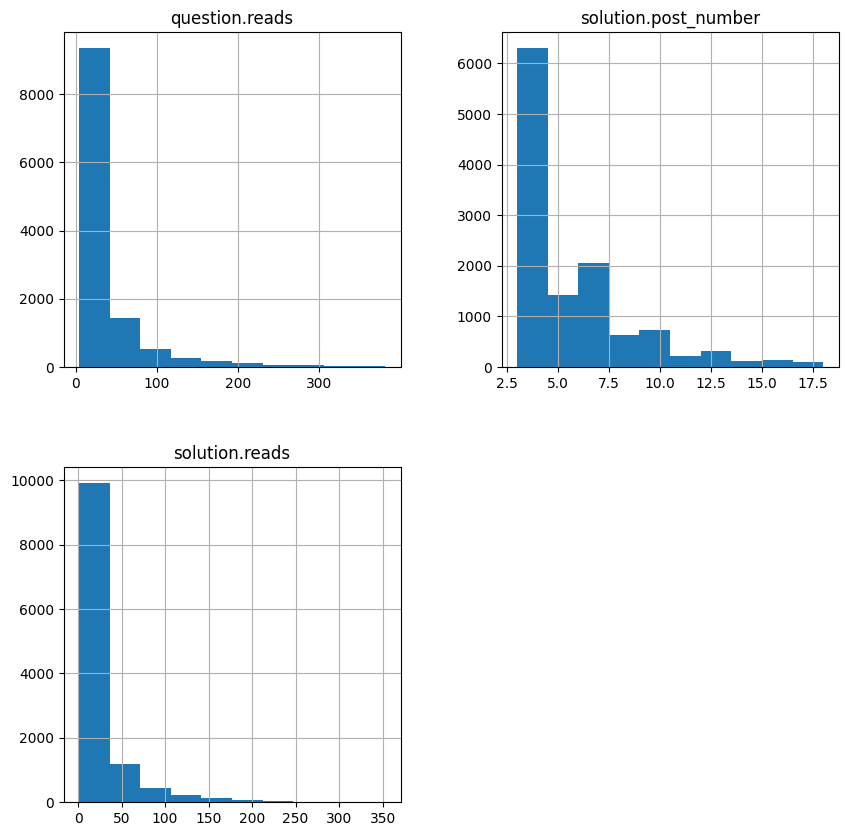

In [160]:
q_low = df["question.reads"].quantile(0.01)
q_hi  = df["question.reads"].quantile(0.99)

df_filtered = df[(df["question.reads"] < q_hi) & (df["question.reads"] > q_low)]

q_low = df["solution.post_number"].quantile(0.01)
q_hi  = df["solution.post_number"].quantile(0.99)

df_filtered = df_filtered[(df_filtered["solution.post_number"] < q_hi) & (df_filtered["solution.post_number"] > q_low)]

df_filtered.select_dtypes(include=np.number).hist(figsize=[10,10])
plt.show()

### Eland Machine Learning

You can use Eland to bring ML models into Elastic and use them on your data. 

See docs here: https://www.elastic.co/guide/en/elasticsearch/client/eland/current/machine-learning.html

In [101]:
training = df[["duration", "question.reads", "solution.post_number", "solution.reads"]].to_pandas().iloc[:200]
new = df[["duration", "question.reads", "solution.post_number", "solution.reads"]].to_pandas().iloc[200:220]

In [ ]:
pd_df = df[["category_name"]].to_pandas().iloc[0:220]
encodings = pd.factorize(pd_df["category_name"], use_na_sentinel=False)[0]

training_target = pd_df.iloc[:200]
training_target["encodings"] = encodings[0:200]
new_target = pd_df.iloc[200:220]
new_target["encodings"] = encodings[200:220]


In [140]:
print(training)
print(training_target)

        duration  question.reads  solution.post_number  solution.reads
194038      1014               5                     3               5
194051      1291              16                     4              12
194052      8562              30                    16              11
194058      1827             102                    21              48
194074       281              36                     7              21
...          ...             ...                   ...             ...
205094        60               8                     2               7
205106       363               6                     2               5
205114       614              31                     2              27
205116      1359              14                     4              13
205119      7147              64                     6              33

[200 rows x 4 columns]
        category_name  encodings
194038       Logstash          0
194051         Kibana          1
194052         Kibana    

As an example, we can take a simple model from scikit-learn and use it on our numeric features. You can see the comparison between running the model in this python environment, or using the trained model directly from Elastic

In [151]:
from sklearn import datasets
from xgboost import XGBClassifier
from eland.ml import MLModel

# Train and exercise an XGBoost ML model locally
training_data = datasets.make_classification(n_features=5)
xgb_model = XGBClassifier(booster="gbtree")
xgb_model.fit(training.values, training_target["encodings"].values)

xgb_model.predict(new.values)

array([4, 0, 0, 1, 1, 1, 6, 3, 1, 1, 3, 3, 4, 4, 3, 3, 1, 3, 3, 1])

In [152]:
# Import the model into Elasticsearch
es_model = MLModel.import_model(
    es_client=client,
    model_id="xgb-classifier_bytes_0",
    model=xgb_model,
    feature_names=["f0", "f1", "f2", "f3", "f4"],
)

# Exercise the ML model in Elasticsearch with the training data
es_model.predict(new.values)

array([4, 0, 0, 1, 1, 1, 6, 3, 1, 1, 3, 3, 4, 4, 3, 3, 1, 3, 3, 1])

### Eland For NLP + Huggingface

We will now take a look at what we can do with our non-numeric features. There are a large number of supported models we support with Eland for various tasks like sentiment analysis, embeddings, or entity recognition. 

See full list of supproted models here: https://www.elastic.co/guide/en/machine-learning/current/ml-nlp-model-ref.html 


In [6]:
import re
pd_df = df[['question.text', 'solution.text']].to_pandas()
pd_df_clean = pd_df.applymap(lambda x: re.sub("<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});r'[^ \w+]'", '', str(x)))

In [7]:
pd_df_clean

,question.text,solution.text
194038,"Hello,\nI have a problem with my filter, i get...","A space was missing , that's why it wasn't wor..."
194051,TL;DR\nHow do I continuously update an alias t...,My workaround for this was to add the followin...
194052,"Hi there,\nI am attempting to stream logs from...","Please try the following, tested locally in 6...."
194058,\n\nThere is no pipeline plugin. Unlike other ...,Okay. I have solved the pipeline virtual addre...
194074,"Hi all,\nI am using version 7.2.\nI encountere...",Can you do the 'grep -rn ...' and verify that ...
...,...,...
343469,"Hi,\nI want to integrate the AWS logs into my ...",\n\n\n rachelyang:\n\n10.0.9.12 46 96 2 1.51 2...
343471,I see that the saved objects API is deprecated...,"Hello @emmanuel_t,\nThis API should still work..."
343472,I have ECK setup and running on my kubernetes ...,It looks like part of my issue was a typo in t...
343478,I have a pipeline whereby the input section lo...,"\n\n\n mikec1:\n\nschedule =&gt; ""0 0 0 * * ?""..."


We have cleaned the data and we will now get it into the right format to make calls to our inference API.

In [52]:
docs_questions = pd_df_clean["question.text"].values
docs_solutions = pd_df_clean["solution.text"].values

docs = []
r = docs_questions.size
for i in range (0,r):
    docs.append({"text_field" : docs_questions[i]})
    docs.append({"text_field" : docs_solutions[i]})

docs

[{'text_field': 'Hello,\nI have a problem with my filter, i get the "_grokparsefailure" tag when the concerned logs are processed.\nHere is my filter file:\nfilter {\nif [source] == "/var/log/auth.log"{\ngrok {\nmatch =&gt;  [ "message", "%{SYSLOGTIMESTAMP:date} %{SYSLOGHOST:host} %{DATA:program}(?:[%{POSINT:pid}])?: %{GREEDYDATA:smt}: %{GREEDYDATA:smt2} for user %{USER:user}" ]\nadd_field =&gt; [ "received_at", "%{@timestamp}" ]\nadd_field =&gt; [ "received_from", "%{host}" ]\n}\ndate {\nmatch =&gt;  [ "date", "MMM d HH:mm:ss", "MMM dd HH:mm:ss" ]\n}\n}\n}\nI tried it with the input: "Aug  6 12:17:01 stack CRON[14336]: pam_unix(cron:session): session closed for user root" on  http://grokdebug.herokuapp.com/  and it works fine.\nIs there any problem with my code ?\nThank you,\nManal'},
 {'text_field': "A space was missing , that's why it wasn't working. I fixed it. Thank you !"},
 {'text_field': 'TL;DR\nHow do I continuously update an alias to capture new matching index patterns?\nLong

### Docker setup + model import

To make sure things run smoothly with all the requirements and versioning for pytorch and the Elastic clients, we recommend using the docker containers for the NLP tasks. 

See the docs here: https://www.elastic.co/guide/en/elasticsearch/client/eland/current/machine-learning.html#ml-nlp-pytorch

We have recently published a docker client for Eland so you can directly pull it from here rather than building the container locally:

https://container-library.elastic.co/r/eland/eland:8.9.0

```
docker pull docker.elastic.co/eland/eland:8.9.0
```

You can build the docker in your environment by running the following code in your terminal (and using your credentials locally)

export CLOUD_ID=change_me

```
docker run -it --rm docker.elastic.co/eland/eland:8.9.0 \
    eland_import_hub_model \
      --cloud-id $CLOUD_ID \
      -u $USER -p $PASSWORD \
      --hub-model-id distilbert-base-uncased-finetuned-sst-2-english \
      --task-type text_classification \
      --start 
```

### Importing Sentiment Analysis from Huggingface

In [53]:
from elasticsearch.client import MlClient

model_id = "distilbert-base-uncased-finetuned-sst-2-english"

models = MlClient.get_trained_models(client, model_id=model_id)
models.body

stats = MlClient.get_trained_models_stats(client, model_id=model_id)
stats.body['trained_model_stats'][0]['deployment_stats']['nodes'][0]['routing_state']

/var/folders/k3/sm4kh0y91fs5_fft4375wwh00000gn/T/ipykernel_3232/78141079.py:1: DeprecationWarning: Importing from the 'elasticsearch.client' module is deprecated. Instead use 'elasticsearch' module for importing the client.
  from elasticsearch.client import MlClient


{'routing_state': 'started'}

In [66]:
stats = MlClient.get_trained_models_stats(client, model_id=model_id)
stats.body['trained_model_stats'][0]['deployment_stats']['nodes'][0]['routing_state']

{'routing_state': 'started'}

You can make calls to the model locally, or create a pipeline that applies the transformation to your entire index

In [73]:
response = MlClient.infer_trained_model(client, model_id=model_id, docs=docs[0:10], timeout=None)["inference_results"]

In [77]:
for i in range(0,10):
   docs[i]["probability"] = response[i]["predicted_value"]
   docs[i]["score"] = response[i]["prediction_probability"]

In [78]:
docs[0:10]

[{'text_field': 'Hello,\nI have a problem with my filter, i get the "_grokparsefailure" tag when the concerned logs are processed.\nHere is my filter file:\nfilter {\nif [source] == "/var/log/auth.log"{\ngrok {\nmatch =&gt;  [ "message", "%{SYSLOGTIMESTAMP:date} %{SYSLOGHOST:host} %{DATA:program}(?:[%{POSINT:pid}])?: %{GREEDYDATA:smt}: %{GREEDYDATA:smt2} for user %{USER:user}" ]\nadd_field =&gt; [ "received_at", "%{@timestamp}" ]\nadd_field =&gt; [ "received_from", "%{host}" ]\n}\ndate {\nmatch =&gt;  [ "date", "MMM d HH:mm:ss", "MMM dd HH:mm:ss" ]\n}\n}\n}\nI tried it with the input: "Aug  6 12:17:01 stack CRON[14336]: pam_unix(cron:session): session closed for user root" on  http://grokdebug.herokuapp.com/  and it works fine.\nIs there any problem with my code ?\nThank you,\nManal',
  'probability': 'POSITIVE',
  'score': 0.9826626663460409},
 {'text_field': "A space was missing , that's why it wasn't working. I fixed it. Thank you !",
  'probability': 'POSITIVE',
  'score': 0.961033

### Add NLP enrichment to index through pipelines

You can create this pipeline in your dev tool.

In [ ]:
PUT _ingest/pipeline/sentiment
{
  "processors": [
    {
      "inference": {
        "model_id": "distilbert-base-uncased-finetuned-sst-2-english",
        "field_map": {
          "Question.text": "text_field"
        }
      }
    }
  ]
}
POST _reindex?wait_for_completion=false
{
  "source": {
    "index": "bytes-discuss-06"
  },
  "dest": {
    "index": "bytes-discuss-06-with-sentiment",
    "pipeline": "sentiment"
  }
}